<a href="https://colab.research.google.com/github/rhapsodic-legacy/streamflow_prediction/blob/main/streamflow_time_series_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate Time Series Flood Prediction
##### Ten Day Forecast, Top 10 Watersheds (rated by discharge value availability in the last 20 years of that watershed's recordings). 

### Phase One: Isolating the correct data to build a model upon. 
##### Each watershed has differing characteristics, so any given model prediction will be for a certain watershed. The target variable that directly correlates to a flood, is 'discharge'. 
##### Some watersheds have most of their discharge values available for model training, most have many missing values, and some are missing more than 90% of their discharge values. This is due to varying factors. 
#### For Watershed 8, this model's sMAPE score is: 32.18931624946136

In [1]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math, time
import sklearn as sk

In [4]:
# Copy this file to a local drive. In this case, Google Drive. 
!cp /content/drive/MyDrive/Kalman_Filter/top_ten_watersheds.csv /content/

In [5]:
df = pd.read_csv('top_ten_watersheds.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,175,0.966122,-21.574120,-27.607310,NaN
1,1950-01-02,175,1.008771,-25.995184,-31.368013,NaN
2,1950-01-03,175,0.000000,-28.295700,-38.181858,NaN
3,1950-01-04,175,0.000000,-26.836973,-39.946175,NaN
4,1950-01-05,175,0.000000,-29.592003,-37.728634,NaN


In [6]:
df.watershed.unique()

array([175,   8, 205, 159, 252, 110, 214,  27, 147, 236])

### Phase Two: Data Cleaning and Feature Selection

In [9]:
# As watershed 8 had the second most discharge values, it will be explored. 
shed8 = df[(df['watershed'] == 8)]
shed8.tail()

,time,watershed,pr,tasmax,tasmin,discharge
50399,2018-12-27,8,0.000000,-4.525000,-12.713847,NaN
50400,2018-12-28,8,3.095808,-4.477844,-7.687799,NaN
50401,2018-12-29,8,10.622604,4.529790,-5.354715,NaN
50402,2018-12-30,8,5.917290,1.838473,-13.661377,NaN
50403,2018-12-31,8,0.518263,-9.067141,-23.757261,NaN


In [11]:
# It seems watershed 8 has null values towards the end of its readings. 
# Observe when the last recorded discharge value was. 
copy = shed8.copy()
copy.dropna(inplace=True)
copy.tail()

,time,watershed,pr,tasmax,tasmin,discharge
49303,2015-12-27,8,0.450599,-3.780838,-7.854042,9.02
49304,2015-12-28,8,3.350823,-3.364820,-11.941392,7.74
49305,2015-12-29,8,0.518263,-6.307036,-17.437800,7.10
49306,2015-12-30,8,0.000000,-6.492216,-17.942291,7.20
49307,2015-12-31,8,1.320734,-6.581362,-11.561751,7.61


In [12]:
# We will be focusing on the past twentyfive years of data. 
# As 2015 was the last year of recordings, 1991 forward will be taken. 
shed8 = shed8[(shed8['time'] > '1990-12-31')]

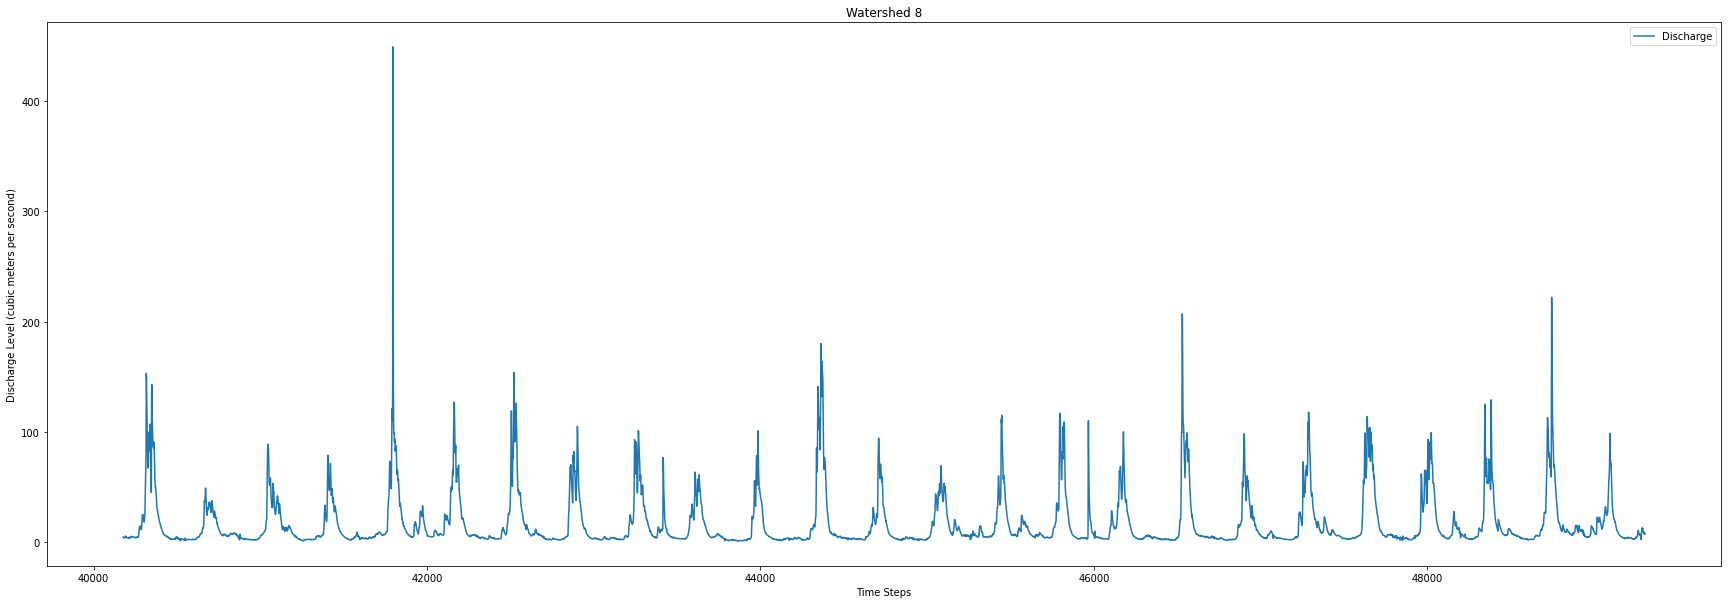

In [13]:
# For visual representation, plotting discharge of watershed 8
x = range(len(shed8))
y = shed8.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 8")
plt.xlabel("Time Steps (days forward from Jan.1 1991") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()

In [14]:
# There doesn't appear to be many missing discharge values. 
# Measure how many NaN's there are. 
shed8.isna().sum()

time            0
watershed       0
pr              0
tasmax          0
tasmin          0
discharge    1096
dtype: int64

In [15]:
# For this watershed, the missing values do not acrue near peak discharge moments. 
# Using Pandas built in function 'interpolate', nan values will be filled in. 

# Switching the 'time' column to the datetime format.
shed8["time"] = pd.to_datetime(shed8["time"])

In [16]:
shed8.set_index('time', inplace = True)
for watershedID in set(shed8["watershed"]):
  shed8[shed8["watershed"] == watershedID] = shed8[shed8["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")

In [17]:
"""# For visual representation, plotting discharge of watershed 8

x = range(len(shed175))
y = shed175.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1991)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()"""

'# For visual representation, plotting discharge of watershed 8\n\nx = range(len(shed175))\ny = shed175.discharge\n\nf = plt.figure()\nf.set_figwidth(30)\nf.set_figheight(10)\nplt.title("Watershed 175")\nplt.xlabel("Time Steps (days forward from January 1, 1991)") # A track varies in timing, but averages to every 3 days.\nplt.ylabel("Discharge Level (cubic meters per second)")\nplt.plot(y, label = \'Discharge\')\n\nplt.legend()\nplt.show()'

In [30]:
# Dropping the rows that are NaN at the end. 
shed8 = shed8[(shed8.index < '2016-01-01')]

In [31]:
# For purposes of ease of experimentation, a copy will be made of the dataframe. 
model = shed8.copy()

In [32]:
# Herein we will create a function that creates represenations of the past days. 
# And A fortnight is the target variable. --> This can be changed to 10 days out, instead of 14. 

def advance(x):
  num_list = []
  length = len(model.discharge)
  for i in range(length):
    if x + i >= length: # For calculating the target variable
      num = i
    elif i + x < 0: # For calculating the past. 
      num = i
    else:
      num = i + x # Other than the outliers, the value will be discharge[i + 'x']
    forecast = model['discharge'][num]
    num_list.append(forecast)
  name = f"discharge_{x}"    
  model[name] = num_list #model1['discharge'][num]

In [33]:
# The target forecast was identified as 10 days, by a NRCan representative. 
advance(10)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10
time,,,,,,
1991-01-01,8,5.387799,-16.682634,-20.962350,4.70,4.07
1991-01-02,8,0.874177,-4.969985,-31.367516,4.56,4.25
1991-01-03,8,0.428518,-11.568413,-27.783907,4.43,5.20
1991-01-04,8,0.133608,-13.293263,-27.338250,4.24,5.41
1991-01-05,8,0.000000,-13.462649,-25.158234,4.15,5.44


In [34]:
# Next a column representing the past week's cumulative rainfall. 

def rainfall(x):
  rainfall = []
  length = len(model.discharge)
  for i in range(length):
    # In this case, we're only interested in the past rainfall. 
    if i + x < 0:
      answer = model.pr[:i+1].sum()
    else:
      num = i + x
      answer = model.pr[num:i].sum()
    rainfall.append(answer)
  name = f"pr_{x}"
  model[name] = rainfall
  

In [35]:
rainfall(-7)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10,pr_-7
time,,,,,,,
1991-01-01,8,5.387799,-16.682634,-20.962350,4.70,4.07,5.387799
1991-01-02,8,0.874177,-4.969985,-31.367516,4.56,4.25,6.261976
1991-01-03,8,0.428518,-11.568413,-27.783907,4.43,5.20,6.690494
1991-01-04,8,0.133608,-13.293263,-27.338250,4.24,5.41,6.824102
1991-01-05,8,0.000000,-13.462649,-25.158234,4.15,5.44,6.824102


In [36]:
# For the purposes of this iteration of the model, only precipitation and discharge values will be kept. 
model = model.drop(['watershed', 'tasmax', 'tasmin'], axis=1)

### Phase Three: Building the Multivariate Time Series Model


In [57]:
time_shift = 10

target_data = model['discharge'].shift(time_shift)
data = model.iloc[:-time_shift]
data

TypeError: ignored

In [58]:
test_head = data.index[int(0.75*len(data))]
test_head

Timestamp('2009-09-23 00:00:00')

In [59]:
df_train = data.loc[:test_head,:]
df_test = data.loc[test_head:,:]
target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

In [60]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [61]:
i = 27
sequence_length = 10
features = ['pr', 'discharge', 'pr_-7']
target = 'discharge_10'

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[ 0.0000,  4.7800, 42.4820],
        [ 0.0000,  4.5800, 26.4868],
        [ 0.0000,  4.4700, 24.4445],
        [ 9.7153,  4.2700, 22.3264],
        [ 5.0152,  3.9700, 26.3853],
        [ 1.9975,  3.9900, 27.4752],
        [ 0.1479,  4.0500, 28.1701],
        [ 0.8742,  4.0600, 16.8759],
        [11.4553,  4.0500, 17.7501],
        [ 0.0000,  4.0100, 29.2054]])


In [62]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 10, 3])
tensor([[[ 0.0000,  3.3600,  3.5692],
         [ 0.0000,  3.1800,  3.5513],
         [ 0.0000,  2.9100,  0.0178],
         [ 0.0000,  2.8800,  0.0000],
         [ 0.0000,  2.6900,  0.0000],
         [ 0.0000,  2.7700,  0.0000],
         [ 0.0000,  2.7600,  0.0000],
         [12.6823,  2.9400,  0.0000],
         [ 0.0000,  2.5500, 12.6823],
         [ 0.0000,  2.7000, 12.6823]],

        [[ 0.2826, 10.0000,  6.7942],
         [ 0.4973,  9.7600,  7.0767],
         [ 0.2117,  9.1800,  7.5740],
         [ 0.0000,  8.5000,  7.7857],
         [ 0.1070,  8.4200,  7.7857],
         [ 0.5015,  8.0300,  7.8927],
         [ 1.3687,  7.7500,  8.1633],
         [ 1.6115,  7.1400,  2.9688],
         [ 1.9966,  6.8800,  4.2977],
         [ 3.9438,  6.5400,  5.7969]],

        [[ 0.0000,  3.3300,  9.6689],
         [ 0.0000,  3.1600,  8.1443],
         [ 2.5710,  3.1500,  5.5967],
         [ 3.5251,  3.1000,  4.5971],
         [ 3.8838,  3.1200,  7.6207],
         [ 1.3013,  3.1

In [63]:
batch_size = 4
sequence_length = 10

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 10, 3])
Target shape: torch.Size([4])


In [66]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [67]:
learning_rate = 5e-5
num_hidden_units = 64

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(50):
    
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 958.5912810916867

Epoch 0
---------
Train loss: 808.1738400491687
Test loss: 766.364804306149

Epoch 1
---------
Train loss: 676.0475414297878
Test loss: 673.6683317415266

Epoch 2
---------
Train loss: 606.6485758453155
Test loss: 612.6645304450159

Epoch 3
---------
Train loss: 553.1051054010957
Test loss: 557.5918662941276

Epoch 4
---------
Train loss: 507.45329811923915
Test loss: 511.7809171734864

Epoch 5
---------
Train loss: 470.09750119512677
Test loss: 471.7999472601206

Epoch 6
---------
Train loss: 437.78671114713234
Test loss: 436.83489548409074

Epoch 7
---------
Train loss: 410.603536526267
Test loss: 407.05834632898285

Epoch 8
---------
Train loss: 387.3106307084844
Test loss: 379.59043839874624

Epoch 9
---------
Train loss: 366.63712629656817
Test loss: 355.86593990930845

Epoch 10
---------
Train loss: 348.92844853412157
Test loss: 335.69862362570024

Epoch 11
---------
Train loss: 333.1415639385627
Test loss: 317.3827149784502



In [69]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


            discharge_10  Model forecast
time                                    
1991-01-01          4.07        4.374395
1991-01-02          4.25        4.523427
1991-01-03          5.20        5.121223
1991-01-04          5.41        5.441645
1991-01-05          5.44        5.630933
...                  ...             ...
2015-12-17          9.02       11.673494
2015-12-18          7.74       11.867979
2015-12-19          7.10        9.640316
2015-12-20          7.20        9.345924
2015-12-21          7.61        9.299837

[9122 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


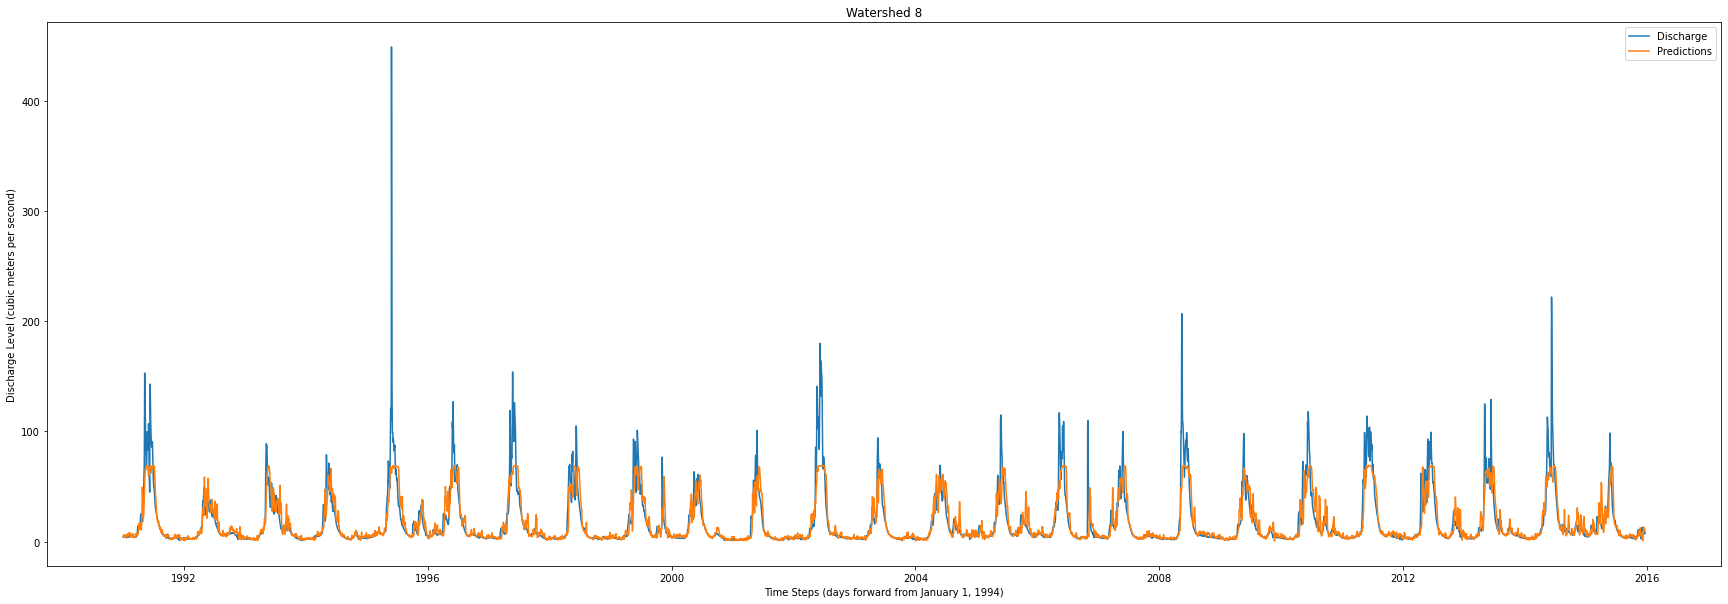

In [70]:
# For visual representation, plotting discharge of watershed 8

x = range(len(shed8))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 8")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()

In [71]:
# We are using SMAPE to measure the performance of our models. 
total = 0
for i in range(len(df_out)):
  predict = df_out['Model forecast'][i]
  recorded = df_out.discharge_10[i]
  top = np.abs(predict - recorded)
  bottom = ((predict + recorded)/2)
  answer = top/bottom
  total += answer
smape = total/len(df_out) * 100
print("For Watershed 8, this model's sMAPE score is:", smape)

For Watershed 8, this model's sMAPE score is: 32.18931624946136


In [ ]:
# Plotting the loss scores, both training and test. 

x = range(len(shed175))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()